# Lognormal density-split model vs. AbacusSummit dark matter halos

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction

from densitysplit.corr_func_utils import get_split_poles
from densitysplit.lognormal_model import *

# to automatically reload imported modules when executing cell
%load_ext autoreload
%autoreload 2

setup_logging()
    
plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

plots_dir = '/feynman/home/dphp/mp270220/plots/densitysplit'

2024-06-13 10:43:24.889026: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rhel-8.x86_64/gnu9/hdf5/1.10.8/lib:/opt/rhel-8.x86_64/modulefiles/gsl/26/lib:/datablock:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib:/feynman/work/dphp/adematti/cosmo/cosmodesiconda/20230918-1.0.0/common/planck/code/plc_3.0/plc-3.1/lib:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/aux/lib
2024-06-13 10:43:24.889078: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Global parameters

In [2]:
# Mock parameters
boxsize = 2000
boxcenter = 1000
nmesh = 1024
cosmology=fiducial.AbacusSummitBase()
z = 0.8
ells = [0]
nells = len(ells)

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

In [3]:
from densitysplit import catalog_data
catalog = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}.npy'.format(z))
nbar = catalog.size/(boxsize**3)
print(nbar)

0.003442710625


## Mock $\delta_R$

In [4]:
density_dir = '/feynman/work/dphp/mp270220/outputs/density/'
simname = 'AbacusSummit_2Gpc_z{:.3f}_ph000'.format(z)

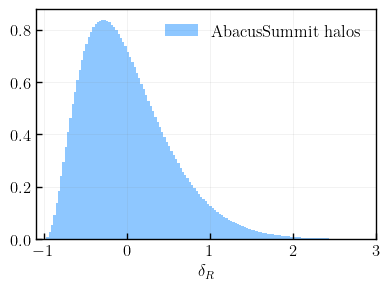

In [5]:
# halos
density_fn = simname.format(0)+'_cellsize{:d}_resampler{}_delta_R'.format(cellsize, resampler)
sim0_delta_R = np.load(os.path.join(density_dir, density_fn+'.npy'))

plt.figure(figsize = (4, 3))
pdf_sim0 = plt.hist(sim0_delta_R, bins=200, density=True, color='C0', alpha=0.5, label='AbacusSummit halos')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1.1, 3))
plt.legend()
plt.savefig(os.path.join(plots_dir, density_fn+'.pdf'), dpi=500)
plt.show()

### Lognormal model for $\delta_R$

[000005.11]  06-13 10:43  LognormalDensityModel        INFO     Initializing LognormalDensityModel
[000005.62]  06-13 10:43  LognormalDensityModel        INFO     Computing sigma, delta0 from the second and third order moments of the density sample.
[000007.24]  06-13 10:43  LognormalDensityModel        INFO     Seting sigma to 0.301, delta0 to 1.717.


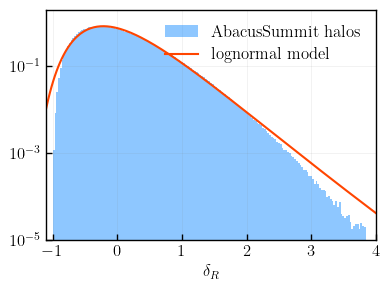

In [6]:
model = LognormalDensityModel()

delta = np.linspace(-1.2, 4, 200)

plt.figure(figsize = (4, 3))
plt.hist(sim0_delta_R, bins=200, density=True, color='C0', alpha=0.5, label='AbacusSummit halos')

sigma, delta0 = model.get_params_from_moments(sample=sim0_delta_R)
plt.plot(delta, model.density(delta), color='C1', label='lognormal model')

#sigma, delta0 = model.fit_params_from_pdf(delta=(pdf_sim0[1][1:]+pdf_sim0[1][:-1])/2, density_pdf=pdf_sim0[0])
#plt.plot(delta, model.density(delta), color='C1', ls=':', label='lognormal model')

plt.xlabel(r'$\delta_R$')
plt.legend()
plt.xlim(-1.1, 4)
plt.yscale('log')
plt.ylim((1e-5, 2))
plt.savefig(os.path.join(plots_dir, density_fn+'_lognormalmodel.pdf'), dpi=500)
plt.show()

## Lognormal model for density splits

In [7]:
nsplits = 3

densitysplitsmodel = LognormalDensitySplitModel(model, nsplits=nsplits)

[000008.75]  06-13 10:43  LognormalDensityModel        INFO     Initializing LognormalDensitySplitsModel with 3 density splits
[000008.76]  06-13 10:43  LognormalDensityModel        INFO     No density bins provided, computing density bins from a lognormal density with sigma = 0.301, delta0 = 1.717: [-1.71664365 -0.27505452  0.15097056         inf].


In [8]:
densitysplitsmodel.set_smoothed_xi_model(redshift=z, cosmology=cosmology, boxsize=1000, nmesh=512, nbar=nbar, non_linear=True)

[000008.78]  06-13 10:43  BaseTwoPointCorrelationFunctionModel INFO     Initializing BaseTwoPointCorrelationFunctionModel
[000008.78]  06-13 10:43  BaseTwoPointCorrelationFunctionModel INFO     Initializing theoretical 1D power spectrum
[000015.15]  06-13 10:43  BaseTwoPointCorrelationFunctionModel INFO     Initializing ParticleMesh with boxisze 1000, nmesh 512
[000015.16]  06-13 10:43  BaseTwoPointCorrelationFunctionModel INFO     Painting 1D power spectrum on 3D mesh


/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/interpolator.py:359: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = (np.asarray(xx, dtype=dtype) for xx in (x, y))


[000030.96]  06-13 10:44  BaseTwoPointCorrelationFunctionModel INFO     3D power spectrum calculated in 15.80 seconds.
[000040.20]  06-13 10:44  BaseTwoPointCorrelationFunctionModel INFO     Initializing SmoothedTwoPointCorrelationFunctionModel
[000040.20]  06-13 10:44  BaseTwoPointCorrelationFunctionModel INFO     Setting smoothing scale to 10
[000040.20]  06-13 10:44  BaseTwoPointCorrelationFunctionModel INFO     Setting 3D smoothing kernel of order 6


/feynman/home/dphp/mp270220/densitysplit/densitysplit/base_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  self.smoothed_sigma = np.sqrt(np.real(xiR))


[000069.31]  06-13 10:44  BaseTwoPointCorrelationFunctionModel INFO     Setting nbar to 0
[000086.44]  06-13 10:44  LognormalDensityModel        INFO     Adding shotnoise correction to the smoothed 2PCF.


## Compare model with density-split correlation functions from 25 AbacusSummit dark matter simulations

In [9]:
# Real space, only monopole
ells = [0]

### Check smoothed 2PCF

In [10]:
# Two-point correlation function measured from 1 AbacusSummit dark matter (DM) simulation
xi_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
simname = 'AbacusSummit_2Gpc_z{:.3f}'.format(z)
xi_fn = simname.format(0)+'_cellsize{:d}_resampler{}_xi_R'.format(cellsize, resampler)
xi = np.load(os.path.join(xi_dir, xi_fn+'.npy'), allow_pickle=True).item()
s, xi = xi.get_corr(ells=ells, return_sep=True)

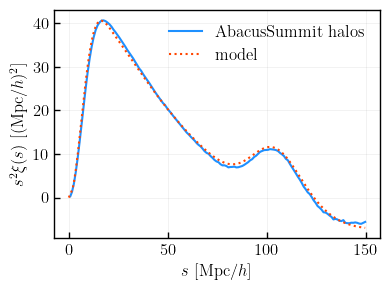

In [11]:
plt.figure(figsize = (4, 3))

bias = 1.485

for ill, ell in enumerate(ells):
    plt.plot(s, s**2 * xi[ill], label='AbacusSummit halos', color='C0')
    plt.plot(densitysplitsmodel.sep, densitysplitsmodel.sep**2 * bias**2 * densitysplitsmodel.smoothed_xi, label=r'model', ls=':', color='C1')

plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.savefig(os.path.join(plots_dir, xi_fn+'.pdf'), dpi=500)
plt.show()

### Density splits

In [12]:
densitysplits = densitysplitsmodel.compute_dsplits(xiR=xi.ravel())

[000097.40]  06-13 10:45  LognormalDensityModel        INFO     Computing lognormal density split model.
[000097.40]  06-13 10:45  LognormalDensityModel        INFO     Setting delta0 to 1.717.
[000097.40]  06-13 10:45  LognormalDensityModel        INFO     No density bins provided, computing density bins from a lognormal density with sigma = 0.301, delta0 = 1.717: [-1.71664365 -0.27505452  0.15097056         inf].
[000097.40]  06-13 10:45  LognormalDensityModel        INFO     Setting delta0 to 1.717.
[000097.40]  06-13 10:45  LognormalDensityModel        INFO     No density bins provided, computing density bins from a lognormal density with sigma = 0.301, delta0 = 1.717: [-1.71664365 -0.27505452  0.15097056         inf].
[000097.40]  06-13 10:45  LognormalDensityModel        INFO     Setting delta0 to 1.717.
[000097.41]  06-13 10:45  LognormalDensityModel        INFO     No density bins provided, computing density bins from a lognormal density with sigma = 0.301, delta0 = 1.717: [-1.

/feynman/home/dphp/mp270220/densitysplit/densitysplit/lognormal_model.py:235: RuntimeWarning: divide by zero encountered in log
  a = scipy.special.erf((np.log(1 + delta/self.delta0) + self.sigma**2/2. - np.log(1 + xiR/(self.delta0*self.delta01))) / (np.sqrt(2) * self.sigma))
/feynman/home/dphp/mp270220/densitysplit/densitysplit/lognormal_model.py:236: RuntimeWarning: divide by zero encountered in log
  b = scipy.special.erf((np.log(1 + delta/self.delta0) + self.sigma**2/2.) / (np.sqrt(2) * self.sigma))


In [13]:
# Density-split cross-correlation functions measured from 25 AbacusSummit DM simulations
simname = 'AbacusSummit_2Gpc_z{:.3f}_ph0{{:02d}}'.format(z)
xi_fn = simname+'_cellsize{:d}_resampler{}_{}splits_randoms_size4_RH_CCF'.format(cellsize, resampler, nsplits)
nmocks = 25
split_xi_list = [np.load(os.path.join(xi_dir, xi_fn.format(i)+'.npy'), allow_pickle=True).item()['rh'] for i in range(nmocks)]
split_xi, cov = get_split_poles(split_xi_list, ells=ells, nsplits=nsplits)
std = np.array_split(np.array(np.array_split(np.diag(cov)**0.5, nells)), nsplits, axis=1)#/np.sqrt(nmocks)
s, _, _ = split_xi_list[0][0].get_corr(return_sep=True)

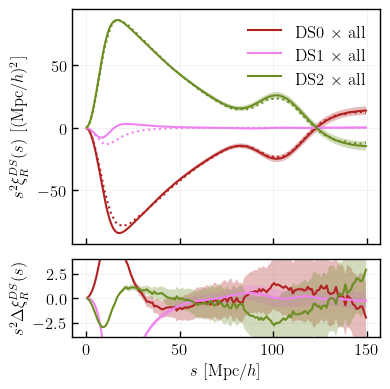

In [14]:
fig, axes = plt.subplots(2, 1, figsize = (4, 4), sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})
colors = ['firebrick', 'violet', 'olivedrab']

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        axes[0].plot(s, s**2 * split_xi[ds][ill], color=colors[ds], label=r'DS{} $\times$ all'.format(ds))
        axes[0].fill_between(s, s**2 * (split_xi[ds][ill] - std[ds][ill]), s**2 * (split_xi[ds][ill] + std[ds][ill]), facecolor=colors[ds], alpha=0.3)
        axes[0].plot(densitysplitsmodel.sep, densitysplitsmodel.sep**2 * densitysplits[ds], ls=':', color=colors[ds])

        diff = densitysplits[ds].ravel() - split_xi[ds][ill]
        axes[1].plot(s, s**2 * diff, color=colors[ds])
        axes[1].fill_between(s, s**2 * (diff - std[ds][ill]), s**2 * (diff + std[ds][ill]), facecolor=colors[ds], alpha=0.3)
axes[1].set_ylim(-4, 4)
axes[1].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
axes[0].set_ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1].set_ylabel(r'$s^2 \Delta \xi_{R}^{DS}(s)$')
fig.align_ylabels()
axes[0].legend()
xi_fn = 'AbacusSummit_2Gpc_z{:.3f}_{}mocks'.format(z, nmocks)+'_cellsize{:d}_resampler{}_{}splits_randoms_size4_RH_CCF'.format(cellsize, resampler, nsplits)
plt.savefig(os.path.join(plots_dir, xi_fn+'_lognormalmodel.pdf'), dpi=500)
plt.show()